In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.chdir('..')

import pickle
import re
from pathlib import Path
import json

import numpy as np
import pandas as pd

from tqdm import tqdm

pd.set_option('display.max_rows', 200)

import matplotlib as mpl
mpl.rcParams['font.size'] = 14           # Base font size
mpl.rcParams['axes.labelsize'] = 14      # Axis label font size
mpl.rcParams['axes.titlesize'] = 14      # Title font size
mpl.rcParams['xtick.labelsize'] = 12     # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 12     # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 13     # Legend font size

## read data for different n mem tokens

In [2]:
model_names = ['EleutherAI/pythia-160m',
               #'EleutherAI/pythia-410m',  'EleutherAI/pythia-1.4b',
               'meta-llama/Llama-3.2-1B', 
               #'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B'
               ]

# load PG-19 & random texts & fanfics
data = []
for model_name in tqdm(model_names):
    for runs_path in ['runs', 'runs_fanfics']:
        load_path = Path(f'./{runs_path}/{model_name}/')
        print(load_path)

        if runs_path == 'runs':
            source = 'pg19'
        elif runs_path == 'runs_fanfics':
            source = 'fanfics'

        for file_path in load_path.glob(f'mem_*_len_*.pkl'):
            if file_path.is_file():
                # Extract max_length from the file name using regex
                match = re.search(f'mem_(\d+)_len_(\d+)(_rnd_vocab_100k)?\.pkl', file_path.name)
                if match:
                    N_mem_tokens = int(match.group(1))
                    max_length = int(match.group(2))
                else:
                    continue

                try:
                    with open(file_path, 'rb') as f:
                        d = pickle.load(f)
                except Exception as e:
                    continue

            try:
                d = pickle.load(open(file_path, 'rb'))
            except:
                continue
            
            for el in d:
                data += [{
                    'model_name': model_name,
                    'max_length': el['max_length'],
                    'n_mem_tokens': el['n_mem_tokens'],
                    'original_loss': el['original_loss'],
                    'original_accuracy': el['original_accuracy'],
                    'best_loss': np.min(el['losses'][:5000]),#el['best_loss'],
                    'best_accuracy': np.max(el['accuracies'][:5000]),#el['best_accuracy'],#np.max(el['accuracies'][:5000]), #
                    'source': source if not el['args'].get('shuffled', False) else 'random',
                }]

    data_df = pd.DataFrame(data)

  0%|          | 0/2 [00:00<?, ?it/s]

runs/EleutherAI/pythia-160m
runs_fanfics/EleutherAI/pythia-160m


 50%|█████     | 1/2 [00:13<00:13, 13.39s/it]

runs/meta-llama/Llama-3.2-1B
runs_fanfics/meta-llama/Llama-3.2-1B


100%|██████████| 2/2 [00:19<00:00,  9.52s/it]


In [3]:
data_df['original_CE'] = data_df['original_loss'] * data_df['max_length']
data_df['best_CE'] = data_df['best_loss'] * data_df['max_length']
data_df['diff_CE'] = data_df['original_CE'] - data_df['best_CE']

# per mem
data_df['original_CE_per_mem'] = data_df['original_loss'] * data_df['max_length'] / data_df['n_mem_tokens']
data_df['best_CE_per_mem'] = data_df['best_loss'] * data_df['max_length'] / data_df['n_mem_tokens']
data_df['diff_CE_per_mem'] = data_df['original_CE_per_mem'] - data_df['best_CE_per_mem']

# similar, but let's count number of correctly predicted tokens
data_df['best_n_correct_tokens'] = data_df['best_accuracy'] * data_df['max_length']
data_df['original_n_correct_tokens'] = data_df['original_accuracy'] * data_df['max_length']
data_df['diff_n_correct_tokens'] = data_df['best_n_correct_tokens'] - data_df['original_n_correct_tokens']

data_df['best_n_correct_tokens_per_mem'] = data_df['best_accuracy'] * data_df['max_length'] / data_df['n_mem_tokens']
data_df['original_n_correct_tokens_per_mem'] = data_df['original_accuracy'] * data_df['max_length']  / data_df['n_mem_tokens']
data_df['diff_n_correct_tokens_per_mem'] = data_df['best_n_correct_tokens_per_mem'] - data_df['original_n_correct_tokens_per_mem']

In [4]:
data_df.head()

,model_name,max_length,n_mem_tokens,original_loss,original_accuracy,best_loss,best_accuracy,source,original_CE,best_CE,diff_CE,original_CE_per_mem,best_CE_per_mem,diff_CE_per_mem,best_n_correct_tokens,original_n_correct_tokens,diff_n_correct_tokens,best_n_correct_tokens_per_mem,original_n_correct_tokens_per_mem,diff_n_correct_tokens_per_mem
0,EleutherAI/pythia-160m,8,1,4.882830,0.142857,0.261007,1.0,pg19,39.062641,2.088054,36.974587,39.062641,2.088054,36.974587,8.0,1.142857,6.857143,8.0,1.142857,6.857143
1,EleutherAI/pythia-160m,8,1,6.018319,0.000000,0.304136,1.0,pg19,48.146549,2.433089,45.713460,48.146549,2.433089,45.713460,8.0,0.000000,8.000000,8.0,0.000000,8.000000
2,EleutherAI/pythia-160m,8,1,3.802093,0.285714,0.751129,1.0,pg19,30.416744,6.009033,24.407712,30.416744,6.009033,24.407712,8.0,2.285714,5.714286,8.0,2.285714,5.714286
3,EleutherAI/pythia-160m,8,1,4.751411,0.428571,0.964425,1.0,pg19,38.011288,7.715398,30.295889,38.011288,7.715398,30.295889,8.0,3.428572,4.571428,8.0,3.428572,4.571428
4,EleutherAI/pythia-160m,8,1,5.125309,0.285714,0.491976,1.0,pg19,41.002472,3.935810,37.066662,41.002472,3.935810,37.066662,8.0,2.285714,5.714286,8.0,2.285714,5.714286


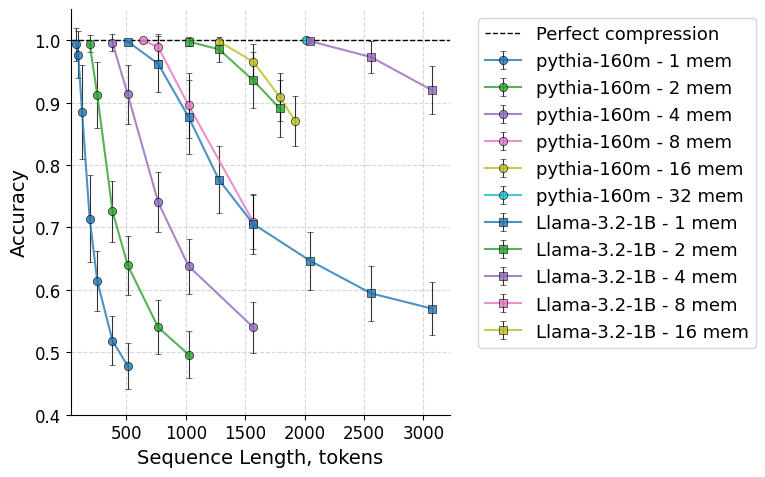

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = data_df[(data_df['source'] == 'pg19')&(data_df['n_mem_tokens']<=32)]

unique_models = df['model_name'].unique()
unique_n_mems = sorted(df['n_mem_tokens'].unique())

# Color palette (one color per n_mem_tokens)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_n_mems)))

# Different marker styles for each model
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', '8']

fig, ax = plt.subplots(figsize=(8, 5))

for i, model in enumerate(unique_models):
    # Filter rows for this model
    for j, n_mem_tokens in enumerate(unique_n_mems):
        sub = df[(df['model_name'] == model)&(df['n_mem_tokens'] == n_mem_tokens)].copy()
        if len(sub) == 0:
            continue
        # Group by max_length, compute mean & std
        grouped = (
            sub.groupby('max_length')['best_accuracy']
            .agg(['mean', 'std'])
            .reset_index()
            .sort_values('max_length')
        )

        x_vals = grouped['max_length'].values
        y_mean = grouped['mean'].values
        y_std  = grouped['std'].values

        # start from point with max length and best accuracy
        st_index = max(np.where(y_mean.max() * 0.99 <= y_mean)[0].max(), 0)
        x_vals, y_mean, y_std = x_vals[st_index:], y_mean[st_index:], y_std[st_index:]

        # Plot with model-specific marker and n_mem_tokens-specific color
        ax.errorbar(
            x_vals,
            y_mean,
            yerr=y_std,
            color=colors[j],       # color based on n_mem_tokens
            ecolor='black',        
            elinewidth=0.8,        
            capsize=2,             
            marker=markers[i],     # marker based on model
            markevery=1,
            errorevery=1,
            markersize=6,          
            markeredgecolor='black',
            markeredgewidth=0.5,   
            linewidth=1.5,
            alpha=0.8,
            label=f"{model.split('/')[-1]} - {n_mem_tokens} mem",
        )

ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1, label='Perfect compression')

ax.set_xlabel("Sequence Length, tokens")
ax.set_ylabel("Accuracy")

ax.set_ylim((0.4, 1.05))
ax.set_xlim((32, 3224))

# Move legend outside plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Clean spines, dashed grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='both', which='major', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [6]:
768, 2048

(768, 2048)

In [ ]:
# find max length bin (or just length) with avg token accuracy >= thr
thr = 0.99
for source in ['pg19']:
    texts_df = data_df[data_df['source'] == source]
    texts_df = texts_df.drop(['source'], axis=1)
    agg_df = texts_df.groupby(['model_name', 'n_mem_tokens', 'max_length']).agg('mean').reset_index()
    max_lengths_df = agg_df[agg_df['best_accuracy'] >= thr].groupby(['model_name', 'n_mem_tokens'], as_index=False).agg({'max_length': 'max'}).sort_values('max_length')
    print(source)
    print(max_lengths_df.sort_values(['model_name', 'n_mem_tokens']))
    print('------------------')

pg19
                 model_name  n_mem_tokens  max_length
0    EleutherAI/pythia-160m             1          80
1    EleutherAI/pythia-160m             2         192
2    EleutherAI/pythia-160m             4         384
3    EleutherAI/pythia-160m             8         640
4    EleutherAI/pythia-160m            16        1280
5    EleutherAI/pythia-160m            32        2016
6    EleutherAI/pythia-160m            64        1792
7    EleutherAI/pythia-160m           128        1792
8   meta-llama/Llama-3.2-1B             1         512
9   meta-llama/Llama-3.2-1B             2        1024
10  meta-llama/Llama-3.2-1B             4        2048
11  meta-llama/Llama-3.2-1B             8        4096
12  meta-llama/Llama-3.2-1B            16        7168
------------------


In [8]:
thr = 0.99
df = data_df[(data_df['best_accuracy'] <= thr)&(data_df['source']=='pg19')].groupby(['source', 'model_name', 'n_mem_tokens']).agg(('mean', 'std'))
df = df.drop(['original_loss', 'original_accuracy', 'best_accuracy', 'best_loss', 'max_length'], axis=1).reset_index().sort_values(['source', ('diff_CE', 'mean')])
df = df.sort_values(['model_name', 'n_mem_tokens'])

In [9]:
df[(df['source']=='pg19')].T

0  \
source                                                    pg19   
model_name                              EleutherAI/pythia-160m   
n_mem_tokens                                                 1   
original_CE                       mean             1004.640662   
                                  std               505.645552   
best_CE                           mean              608.217803   
                                  std                493.56312   
diff_CE                           mean              396.422859   
                                  std                45.997844   
original_CE_per_mem               mean             1004.640662   
                                  std               505.645552   
best_CE_per_mem                   mean              608.217803   
                                  std                493.56312   
diff_CE_per_mem                   mean              396.422859   
                                  std                45.997844   
best_n_correct_tokens             mean              162.543898   
                                  std                52.794984   
original_n_correct_tokens         mean               91.651611   
                                  std                51.085034   
diff_n_correct_tokens             mean               70.892288   
                                  std                10.975483   
best_n_correct_tokens_per_mem     mean              162.543898   
                                  std                52.794984   
original_n_correct_tokens_per_mem mean               91.651611   
                                  std                51.085034   
diff_n_correct_tokens_per_mem     mean               70.892288   
                                  std                10.975483   

                                                             1  \
source                                                    pg19   
model_name                              EleutherAI/pythia-160m   
n_mem_tokens                                                 2   
original_CE                       mean               2037.8814   
                                  std               975.774143   
best_CE                           mean             1209.407562   
                                  std               946.707217   
diff_CE                           mean              828.473839   
                                  std                65.429865   
original_CE_per_mem               mean               1018.9407   
                                  std               487.887071   
best_CE_per_mem                   mean              604.703781   
                                  std               473.353608   
diff_CE_per_mem                   mean              414.236919   
                                  std                32.714932   
best_n_correct_tokens             mean              346.912654   
                                  std               105.283502   
original_n_correct_tokens         mean              196.577406   
                                  std               102.362944   
diff_n_correct_tokens             mean              150.335248   
                                  std                15.468388   
best_n_correct_tokens_per_mem     mean              173.456327   
                                  std                52.641751   
original_n_correct_tokens_per_mem mean               98.288703   
                                  std                51.181472   
diff_n_correct_tokens_per_mem     mean               75.167624   
                                  std                 7.734194   

                                                             2  \
source                                                    pg19   
model_name                              EleutherAI/pythia-160m   
n_mem_tokens                                                 4   
original_CE                       mean             3322.386886   
                                 

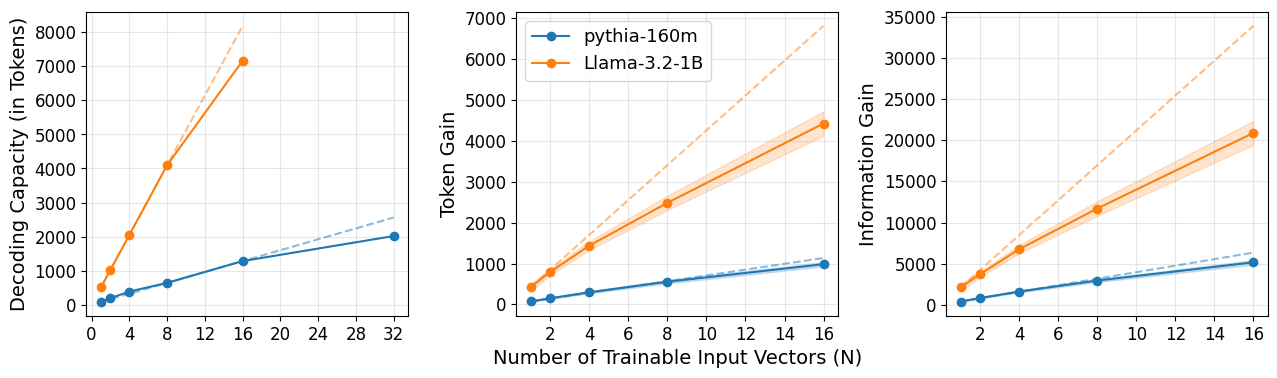

In [10]:
source = 'pg19'
thr = 0.99
max_n_mem = 32  # Add maximum value for n_mem_tokens

# Create figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))

# Filter data for pg19 source
df = data_df[(data_df['best_accuracy'] <= thr)&(data_df['source']=='pg19')].groupby(['source', 'model_name', 'n_mem_tokens']).agg(('mean', 'std'))
df = df.drop(['original_loss', 'original_accuracy', 'best_accuracy', 'best_loss', 'max_length'], axis=1).reset_index().sort_values(['source', ('diff_CE', 'mean')])
df = df.sort_values(['model_name', 'n_mem_tokens'])

pg19_data = df[df['source'] == source]

# Define colors for models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Default matplotlib colors

models = pg19_data['model_name'].unique()

# Plot max_length
texts_df = data_df[data_df['source'] == source]
texts_df = texts_df.drop(['source'], axis=1)
agg_df = texts_df.groupby(['model_name', 'n_mem_tokens', 'max_length']).agg('mean').reset_index()
max_lengths_df = agg_df[agg_df['best_accuracy'] >= thr].groupby(['model_name', 'n_mem_tokens'], as_index=False).agg({'max_length': 'max'}).sort_values('max_length')

for i, model in enumerate(models):
    model_data = max_lengths_df[max_lengths_df['model_name'] == model]
    n_mem_tokens = sorted([n for n in model_data['n_mem_tokens'].unique() if n <= max_n_mem])

    means = []
    for n_mem in n_mem_tokens:
        data = model_data[model_data['n_mem_tokens'] == n_mem]
        means.append(data['max_length'].values[0])
    
    line = ax1.plot(n_mem_tokens, means, '-o', label=model.split('/')[-1], color=colors[i])
    
    # Add ideal linear scaling line
    scale_factor = means[0]  # Scale based on first point
    linear_y = [scale_factor * n for n in n_mem_tokens]
    ax1.plot(n_mem_tokens, linear_y, '--', color=colors[i], alpha=0.5)
            #  label=f'ideal linear scaling')

# ax1.set_xlabel('Number of Trainable Input Vectors (N)')
ax1.set_ylabel('Decoding Capacity (in Tokens)')
# ax1.set_title('Max text length that fits into N vectors.')
# ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot diff_n_correct_tokens
for i, model in enumerate(models):
    model_data = pg19_data[pg19_data['model_name'] == model]
    n_mem_tokens = sorted([n for n in model_data['n_mem_tokens'].unique() if n <= max_n_mem])
    
    means = []
    stds = []
    for n_mem in n_mem_tokens:
        data = model_data[model_data['n_mem_tokens'] == n_mem]
        means.append(data[('diff_n_correct_tokens', 'mean')].values[0])
        stds.append(data[('diff_n_correct_tokens', 'std')].values[0])
    
    line = ax2.plot(n_mem_tokens, means, '-o', label=model.split('/')[-1], color=colors[i])
    ax2.fill_between(n_mem_tokens,
                    [m - s for m, s in zip(means, stds)],
                    [m + s for m, s in zip(means, stds)],
                    alpha=0.2, color=colors[i])
    
    # Add ideal linear scaling line
    scale_factor = means[0]  # Scale based on first point
    linear_y = [scale_factor * n for n in n_mem_tokens]
    ax2.plot(n_mem_tokens, linear_y, '--', color=colors[i], alpha=0.5)
            #  label=f'ideal linear scaling')

ax2.set_xlabel('Number of Trainable Input Vectors (N)')
ax2.set_ylabel('Token Gain')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot diff_CE
for i, model in enumerate(models):
    model_data = pg19_data[pg19_data['model_name'] == model]
    n_mem_tokens = sorted([n for n in model_data['n_mem_tokens'].unique() if n <= max_n_mem])
    
    means = []
    stds = []
    for n_mem in n_mem_tokens:
        data = model_data[model_data['n_mem_tokens'] == n_mem]
        means.append(data[('diff_CE', 'mean')].values[0])
        stds.append(data[('diff_CE', 'std')].values[0])
    
    line = ax3.plot(n_mem_tokens, means, '-o', label=model.split('/')[-1], color=colors[i])
    ax3.fill_between(n_mem_tokens, 
                    [m - s for m, s in zip(means, stds)],
                    [m + s for m, s in zip(means, stds)],
                    alpha=0.2, color=colors[i])
    
    # Add ideal linear scaling line
    scale_factor = means[0]  # Scale based on first point
    linear_y = [scale_factor * n for n in n_mem_tokens]
    ax3.plot(n_mem_tokens, linear_y, '--', color=colors[i], alpha=0.5)
            #  label=f'ideal linear scaling')

# ax3.set_xlabel('Number of Trainable Input Vectors (N)')
ax3.set_ylabel('Information Gain')
# ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig("notebooks/imgs/results_vary_input_tokens.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [11]:
tmp_df = data_df[(data_df['best_accuracy'] <= thr)&(data_df['source']==source)][['model_name', 'n_mem_tokens', 'max_length']]
for mn in tmp_df['model_name'].unique():
    print(mn)
    for n_mem in sorted(tmp_df['n_mem_tokens'].unique()):
        print(n_mem, sorted(tmp_df[(tmp_df['model_name'] == mn) & (tmp_df['n_mem_tokens'] == n_mem)]['max_length'].unique()))

EleutherAI/pythia-160m
1 [80, 96, 128, 192, 256, 384, 512]
2 [192, 256, 384, 512, 768, 1024]
4 [384, 512, 768, 1024, 1568]
8 [768, 1024, 1568]
16 [1280, 1568, 1792, 1920]
meta-llama/Llama-3.2-1B
1 [64, 768, 1024, 1280, 1568, 2048, 2560, 3072]
2 [768, 1024, 1280, 1568, 1792]
4 [1792, 2048, 2560, 3072]
8 [3584, 4096, 4608, 5120]
16 [7168, 7680, 8192, 9216]
